# Run AR6-fair for SSP scenarios from AR6 for creating data for PRIME.


These are idealised emissions runs using data from RCMIP values from 1750 for each of the selected SSP scenarios. 
In this notebook we use the AR6 parameter settings to run a constrained ensemble 
    
    * plot the emissions for some of the pathways
    
    * run the pathways through FaIR , 
    
    * plot some fields (currently only for the first model) to ensure all is well, 
    
    * output to a csv file.


In [1]:
import fair
import matplotlib.pyplot as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.interpolate import interp1d
from multiprocessing import Pool
from tqdm import tqdm
import json
import pickle
#from climateforcing.twolayermodel import TwoLayerModel
from climateforcing.utils import check_and_download, mkdir_p
import os

In [2]:
# set up plotting
pl.rcParams['figure.figsize'] = (9/2.54, 9/2.54)
pl.rcParams['font.size'] = 12
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['ytick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.major.left'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['ytick.right'] = True

In [3]:
# Download FaIR params set
check_and_download(
    'https://zenodo.org/record/5513022/files/fair-1.6.2-wg3-params.json', 
    '../data_input/fair_ar6/'
)

In [4]:
with open('../data_input/fair_ar6/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [5]:
len(config_list)

2237

In [6]:
for k in config_list[0].keys():
    rt_list = []
    rt_list.append(k)
    print (k, len(k))
   
    

F2x 3
r0 2
rt 2
rc 2
lambda_global 13
ocean_heat_capacity 19
ocean_heat_exchange 19
deep_ocean_efficacy 19
b_aero 6
ghan_params 11
scale 5
C_pi 4
E_pi 4
ghg_forcing 11
aCO2land 8
stwv_from_ch4 13
F_ref_BC 8
E_ref_BC 8
F_solar 7
F_volcanic 10
tropO3_forcing 14
b_tro3 6
ozone_feedback 14
natural 7


7
natural 361


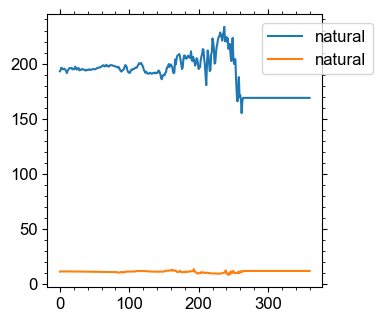

In [7]:
rt_list = []
for c in config_list:
    rt_list.append(c['b_aero'])
#print (rt_list[0])
print (len(rt_list[0]))


rt_list = []
for c in config_list:
    rt_list.append(c['natural'])
print('natural', len(rt_list[0]))
pl.plot(np.arange(361), rt_list[:][0], label=r'natural')
pl.legend(bbox_to_anchor=(0.75, 1), loc='upper left')

In [8]:
rt_list = []
for c in config_list:
    rt_list.append(c["natural"])
print(rt_list[0][0])
print(rt_list[0][1])
print(rt_list[1][0])
print(rt_list[1][1])
len(rt_list[:])

[192.9865502785643, 11.137730226696137]
[194.26764846814376, 11.281236291135704]
[192.9865502785643, 11.137730226696137]
[194.26764846814376, 11.281236291135704]


2237

2237
751
natural 751


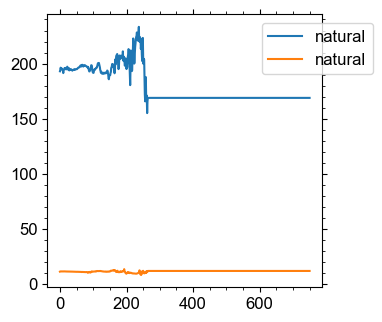

In [9]:
with open('../data_input/fair_ar6/fair-1.6.2-wg3-params.json', "r") as infile:
    all_data = json.load(infile)
    
    # COULD BE: for data in all_data: ... if you don't want to just see the first index
    #data = all_data[0]
    
    for data in all_data:
        for key in data:
            val = data[key]
            # if the value is a list of length 401
            if type(val) == list and len(val) == 361:
                #print(key)
                # for i in range(400 - len(val)): # IF 401 IS HARD CODED, THIS LINE IS UNNECESSARILY COMPLICATED
                for i in range(390):
                    # add the final value 400 - n times
                    val.append(val[-1])
        #print(data)
            
    with open("fair-1.6.2-wg3-params-extended.json", "w") as outfile:
        # this dumps ALL DATA into the new JSON file
        json.dump(all_data, outfile)
        # alternatively, you can dump only THE EDITED DATA with:
        #json.dump(data, outfile)

# double checks it changes as needed
with open("fair-1.6.2-wg3-params-extended.json", "r") as infile:
    extended_data = json.load(infile)
    print(len(extended_data))
    
    new_rt_list = []
    for c in extended_data:
        new_rt_list.append(c['F_solar'])
    print (len(new_rt_list[0]))
    
    new_nat_list = []
    for c in extended_data:
        new_nat_list.append(c['natural'])
    print('natural', len(new_nat_list[0]))
    pl.plot(np.arange(751), new_nat_list[:][0], label=r'natural')
    pl.legend(bbox_to_anchor=(0.75, 1), loc='upper left')

In [10]:
#scenarios = ['constant_forcing', 'constant_emissions', 'zero', 'scenario', 'infrastructure']
#scenarios = ['constant_emissions', 'zero', 'infrastructure', 'scenario']
# zero and constant emissions will be the easy ones, so start with these.

scenarios = ['ssp119',
             'ssp126',
             'ssp245',
             'ssp370',
             'ssp534-over',
             'ssp585',
            ]

len(scenarios)

6

In [11]:
# Download RCMIP emissions
check_and_download(
    'https://zenodo.org/record/4589756/files/rcmip-emissions-annual-means-v5-1-0.csv', 
    '../data_input/rcmip/'
)

In [12]:
ssp_df = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')
years = np.arange(1750, 2501)

startyear = 1750
first_scenyear = 2015
last_scenyear = 2500
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}
# 'ssp119','ssp126','ssp245','ssp370',ssp434','ssp585''

for scenario in scenarios:
    data_out[scenario] = np.ones((751, 40)) * np.nan
    data_out[scenario][:,0] = years
    print(scenario)
    years_future = [2015] + list(range(2020,2501,10))
    for i, specie in enumerate(species):
        
        data_out[scenario][:first_row,i+1] = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f = interp1d(years_future, ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),'2015':'2500'].dropna(axis=1))
        data_out[scenario][first_row:(last_row+1), i+1] = f(np.arange(first_scenyear, last_scenyear+1))*unit_convert[i+1]

ssp119
ssp126
ssp245
ssp370
ssp534-over
ssp585


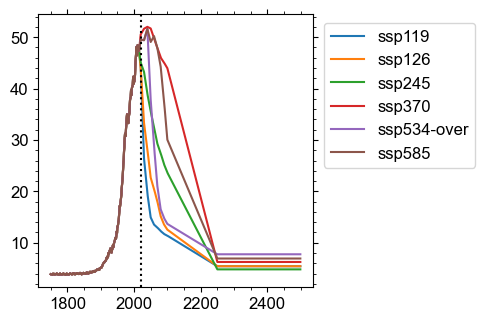

In [13]:
for scenario in scenarios:
    pl.plot(np.arange(1750, 2500), data_out[scenario][0:750,8], label=scenario)    
pl.axvline(2021, ls=':', color='k')
pl.legend(bbox_to_anchor=(1.01, 1), loc='upper left')


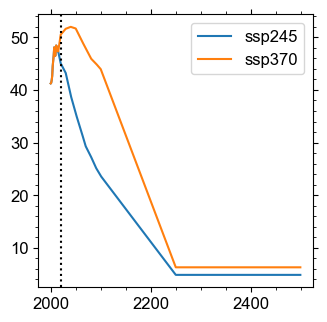

In [14]:
pl.plot(np.arange(2000, 2500), data_out['ssp245'][250:750,8], label='ssp245')
pl.plot(np.arange(2000, 2500), data_out['ssp370'][250:750,8], label='ssp370')
pl.axvline(2021, ls=':', color='k')
pl.legend()


# Try the first ssp before looping through the rest of them.

In [15]:
results_out = {}

In [16]:
updated_config = []
for i, cfg in enumerate(extended_data):
    updated_config.append({})
    for key, value in cfg.items():
        if isinstance(value, list):
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
    updated_config[i]['emissions'] = data_out['ssp119']
    updated_config[i]['diagnostics'] = 'AR6'
    updated_config[i]["efficacy"] = np.ones(45)
    updated_config[i]["gir_carbon_cycle"] = True
    updated_config[i]["temperature_function"] = "Geoffroy"
    updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
    updated_config[i]["fixPre1850RCP"] = False
    updated_config[i]["scale"][43] = 0.6
    #updated_config[i]["F_solar"] = 0.
    #updated_config[i]["F_volcanic"] = 0.
    

In [17]:
print (updated_config[i]['emissions'].shape)
print (updated_config[i]['emissions'])

(751, 40)
[[1.75000000e+03 2.59244179e-03 8.11267109e-02 ... 0.00000000e+00
  1.05087730e+02 4.27574490e+03]
 [1.75100000e+03 2.59253543e-03 8.26192087e-02 ... 0.00000000e+00
  1.05107200e+02 4.27676850e+03]
 [1.75200000e+03 2.59363692e-03 8.41391642e-02 ... 0.00000000e+00
  1.05125020e+02 4.27770490e+03]
 ...
 [2.49800000e+03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.49900000e+03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.50000000e+03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [18]:
#print(updated_config[i]['natural'])
print (updated_config[i]['natural'].shape)
print (len(updated_config[i]['natural']))

(751, 2)
751


In [19]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:26<00:00, 15.27it/s]


In [20]:
len(result[0])

5

In [21]:
len(updated_config)

2237

In [22]:
result_t = np.array(result).transpose(1,2,0)

In [23]:
results_out['ssp119'] = {}
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['ssp119']['co2_conc'] = c
results_out['ssp119']['temp'] = t
results_out['ssp119']['F_ant'] = f_ant
results_out['ssp119']['F_aer'] = f_aer
results_out['ssp119']['F_tot'] = f_tot

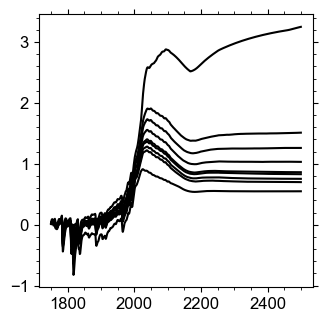

In [24]:
#temp_df = pd.read_csv('../data_input/observations/temp.csv', index_col=0)
#temp_df

for perc in [0,5,10,20,25,50,75,90,100]:
    pl.plot(np.arange(1750,2501),np.percentile(t,perc, axis=1), color='k')


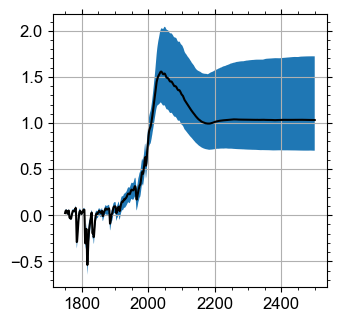

In [25]:
pl.fill_between(np.arange(1750,2501), np.percentile(results_out['ssp119']['temp'], 5, axis=1), np.percentile(results_out['ssp119']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2501), np.percentile(results_out['ssp119']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

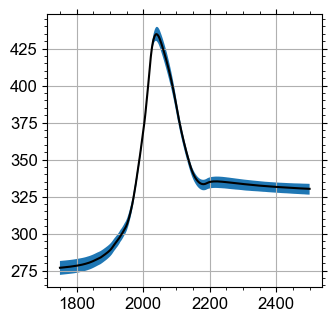

In [26]:
pl.fill_between(np.arange(1750,2501), np.percentile(results_out['ssp119']['co2_conc'], 5, axis=1), np.percentile(results_out['ssp119']['co2_conc'], 95, axis=1))
pl.plot(np.arange(1750,2501), np.percentile(results_out['ssp119']['co2_conc'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

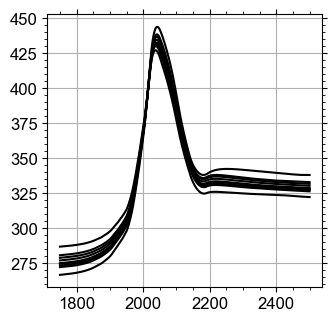

In [27]:
for perc in [0,5,10,20,25,50,75,90,100]:
    pl.plot(np.arange(1750,2501),np.percentile(c,perc, axis=1), color='k')
pl.grid()

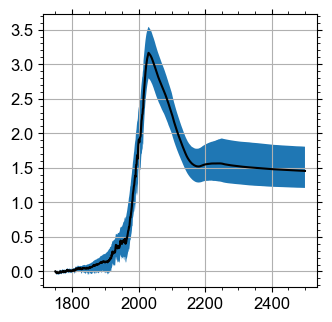

In [28]:
pl.fill_between(np.arange(1750,2501), np.percentile(f_ant, 5, axis=1), np.percentile(f_ant, 95, axis=1))
pl.plot(np.arange(1750,2501), np.percentile(f_ant, 50, axis=1), color='k')
pl.grid()

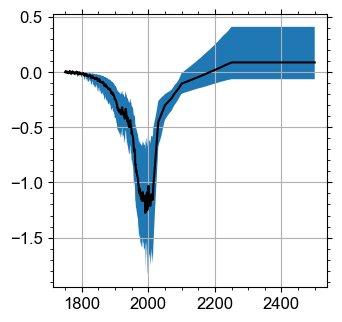

In [29]:
pl.fill_between(np.arange(1750,2501), np.percentile(f_aer, 5, axis=1), np.percentile(f_aer, 95, axis=1))
pl.plot(np.arange(1750,2501), np.percentile(f_aer, 50, axis=1), color='k')
pl.grid()

In [30]:
np.median(results_out['ssp119']['temp'], axis=1)[245:265].mean()

0.9072239871936401

In [31]:
# aerosol forcing is a little less negative than in WG3 because we use CEDS-updated not SSP historical
print(
    np.percentile(results_out['ssp119']['F_aer'], 5, axis=1)[255:265].mean(),
    np.percentile(results_out['ssp119']['F_aer'], 50, axis=1)[255:265].mean(),
    np.percentile(results_out['ssp119']['F_aer'], 95, axis=1)[255:265].mean()
)

-1.682424405229133 -1.1481288262800748 -0.5985614310021965


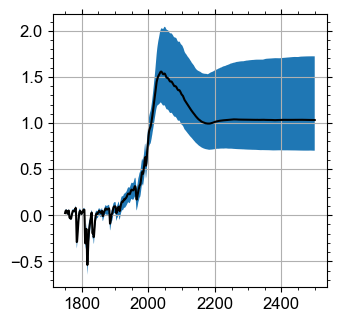

In [32]:
pl.fill_between(np.arange(1750,2501), np.percentile(results_out['ssp119']['temp'], 5, axis=1), np.percentile(results_out['ssp119']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2501), np.percentile(results_out['ssp119']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

# Loop through the other ssp pathways

ssp119


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:49<00:00, 13.22it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ssp126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:44<00:00, 13.58it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ssp245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:47<00:00, 13.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ssp370


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:52<00:00, 12.95it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ssp534-over


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:38<00:00, 14.13it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ssp585


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:37<00:00, 14.16it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


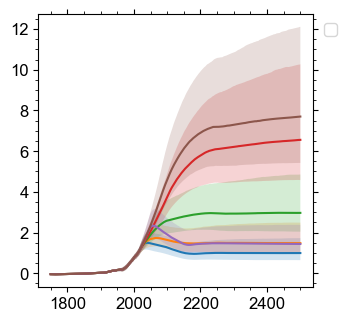

In [33]:
results_out = {}
for scenario in scenarios:
    print (scenario)
    results_out[scenario]={}
    
    updated_config = []
    for i, cfg in enumerate(extended_data):
        updated_config.append({})
        for key, value in cfg.items():
            if isinstance(value, list):
                updated_config[i][key] = np.asarray(value)
            else:
                updated_config[i][key] = value
        updated_config[i]['emissions'] = data_out[scenario]
        updated_config[i]['diagnostics'] = 'AR6'
        updated_config[i]["efficacy"] = np.ones(45)
        updated_config[i]["gir_carbon_cycle"] = True
        updated_config[i]["temperature_function"] = "Geoffroy"
        updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
        updated_config[i]["fixPre1850RCP"] = False
        updated_config[i]["scale"][43] = 0.6
        updated_config[i]["F_solar"] = 0.
        updated_config[i]["F_volcanic"] = 0.
    
    def run_fair(args):
        thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
        return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

    if __name__ == '__main__':
        with Pool(28) as pool:
            result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))
    
    results_out[scenario] = {}
    result_t = np.array(result).transpose(1,2,0)
    c, t, f_ant, f_aer, f_tot = result_t
    temp_rebase = t - t[100:151,:].mean(axis=0)
    temp_rebase_1995_2014 = t - t[245:265,:].mean(axis=0) # subtract 1995-2014 mean  
    
    results_out[scenario]['co2_conc'] = c
    results_out[scenario]['temp'] = t
    results_out[scenario]['temp'] = temp_rebase
    results_out[scenario]['temp_2'] = temp_rebase_1995_2014
    results_out[scenario]['F_ant'] = f_ant
    results_out[scenario]['F_aer'] = f_aer
    results_out[scenario]['F_tot'] = f_tot

    pl.fill_between(np.arange(1750,2501), np.percentile(results_out[scenario]['temp'], 5, axis=1), np.percentile(results_out[scenario]['temp'], 95, axis=1),alpha=0.2)
    pl.plot(np.arange(1750,2501), np.percentile(results_out[scenario]['temp'], 50, axis=1))
    pl.grid()
    pl.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    

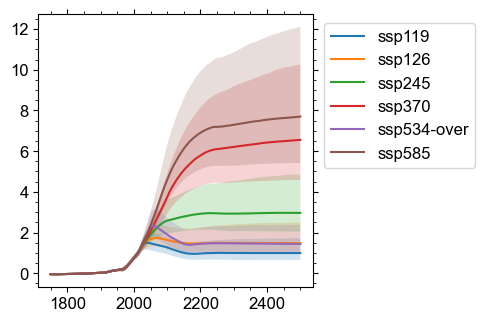

In [34]:
for scenario in scenarios:
    pl.fill_between(np.arange(1750,2501), np.percentile(results_out[scenario]['temp'], 5, axis=1), np.percentile(results_out[scenario]['temp'], 95, axis=1),alpha=0.2)
    pl.plot(np.arange(1750,2501), np.percentile(results_out[scenario]['temp'], 50, axis=1), label=scenario)
    pl.grid()
pl.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    

ssp119


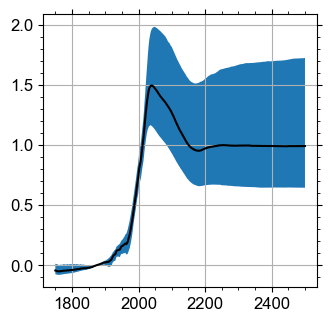

ssp126


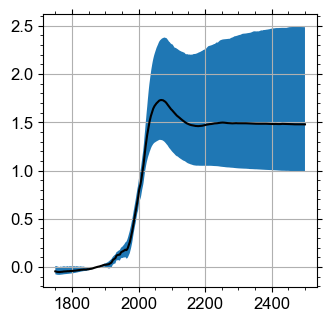

ssp245


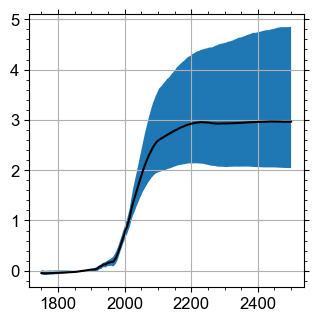

ssp370


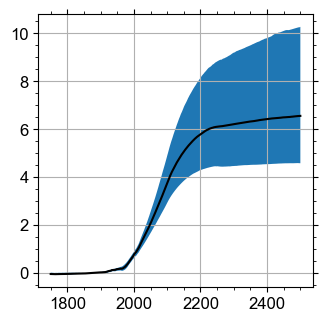

ssp534-over


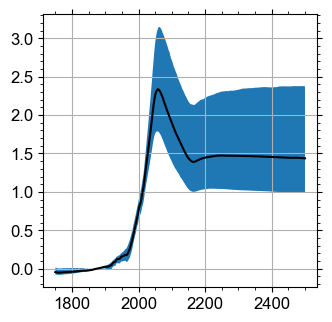

ssp585


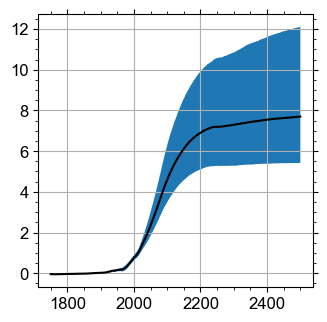

In [35]:
for scenario in scenarios:
    print (scenario)
    pl.fill_between(np.arange(1750,2501), np.percentile(results_out[scenario]['temp'], 5, axis=1), 
                    np.percentile(results_out[scenario]['temp'], 95, axis=1))
    pl.plot(np.arange(1750,2501), np.percentile(results_out[scenario]['temp'], 50, axis=1), color='k')
    #pl.plot(temp_df.index, temp_df.temp, color='r')
    pl.grid()
    pl.pause(5)
   

# All on the same plot!

In [36]:
colors = {'ssp119':'pink',
          'ssp126':'blue',
          'ssp245':'cyan',
          'ssp370':'gold',
          'ssp534-over':'purple', 
          'ssp585':'red'
         }

labels = {'ssp119':'ssp119',
          'ssp126':'ssp126',
          'ssp245':'ssp245',
          'ssp370':'ssp370',
          'ssp534-over':'ssp534-over', 
          'ssp585':'ssp585'
          }

linestyle = {'ssp119':'solid',
          'ssp126':'solid',
          'ssp245':'solid',
          'ssp370':'solid',
          'ssp534-over':'dashed', 
          'ssp585':'dotted'
            }



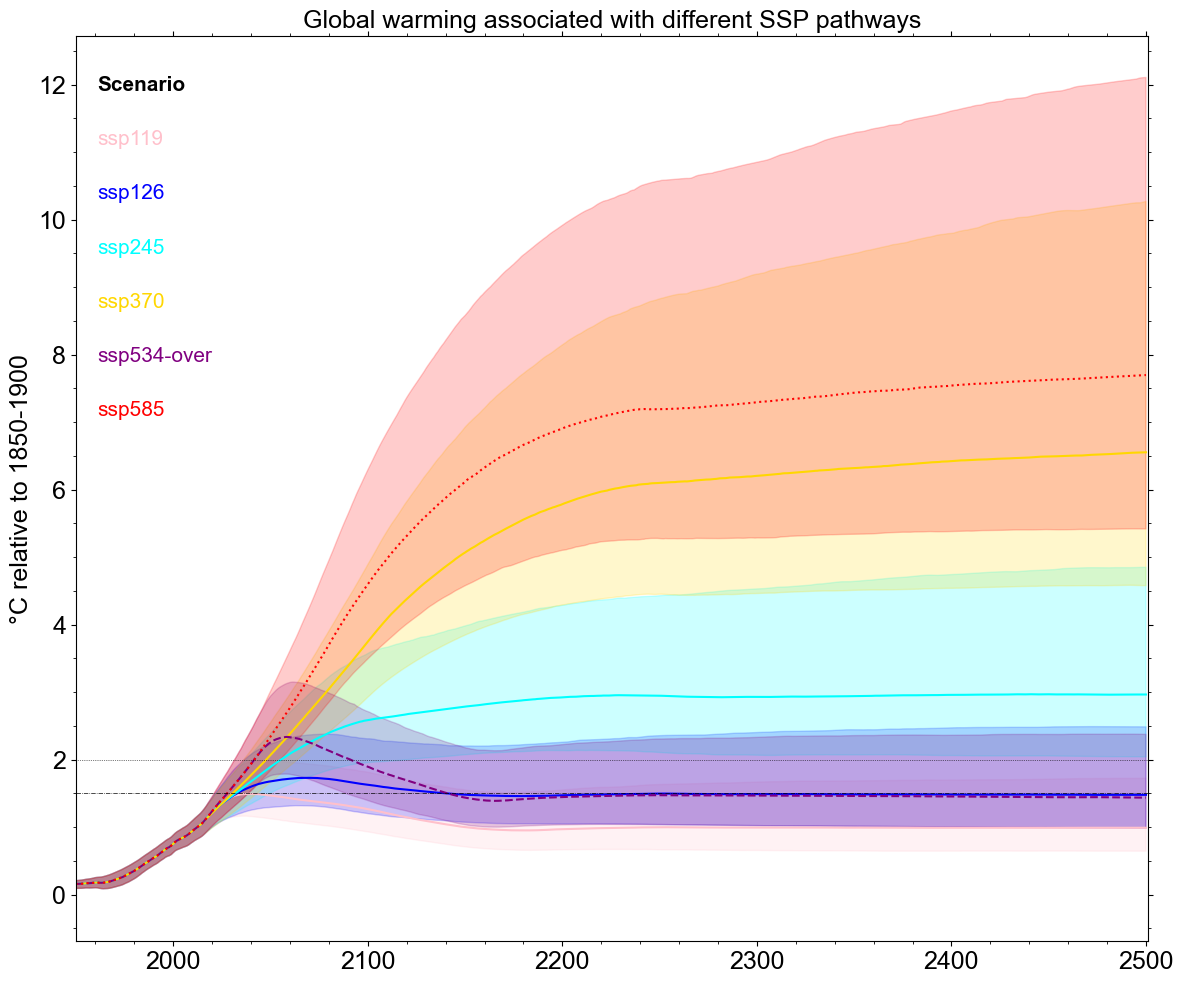

In [37]:
fig, ax = pl.subplots(figsize=(12, 10))

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=15, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(1750,2501), np.percentile(results_out[scenario]['temp'][0:751,:], 5, axis=1), np.percentile(results_out[scenario]['temp'][0:751,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(1750, 2501), np.median(results_out[scenario]['temp'][0:751,:] , axis=1), color=colors[scenario], label=labels[scenario], linestyle=linestyle[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=15)
#ax.legend(fontsize=10);
ax.set_ylabel('°C relative to 1850-1900', fontsize=18);
ax.set_title('Global warming associated with different SSP pathways', fontsize=18);
ax.set_xlim(1950, 2501)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

#ax1 = ax.twinx()
#positions = np.arange(0.75, 2.76, 0.25)

#ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

#ax1.set_ylim(0.75,2.75)
#ax1.spines['right'].set_color('gray')
#ax1.tick_params(axis='y', colors='gray')
#ax1.set_ylabel('°C relative to 1850-1900', color='gray', fontsize=18)


#ax.axhline(0, ls=':', color='k', lw=0.5)
ax.axhline(1.5, ls='-.', color='k', lw=0.5)
#ax1.axhline(1.75, ls='-.', color='k', lw=0.5)
ax.axhline(2.0, ls=':', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/ssp_temps.png', dpi=500, transparent=False)

# All on the same plot CO2 conc!

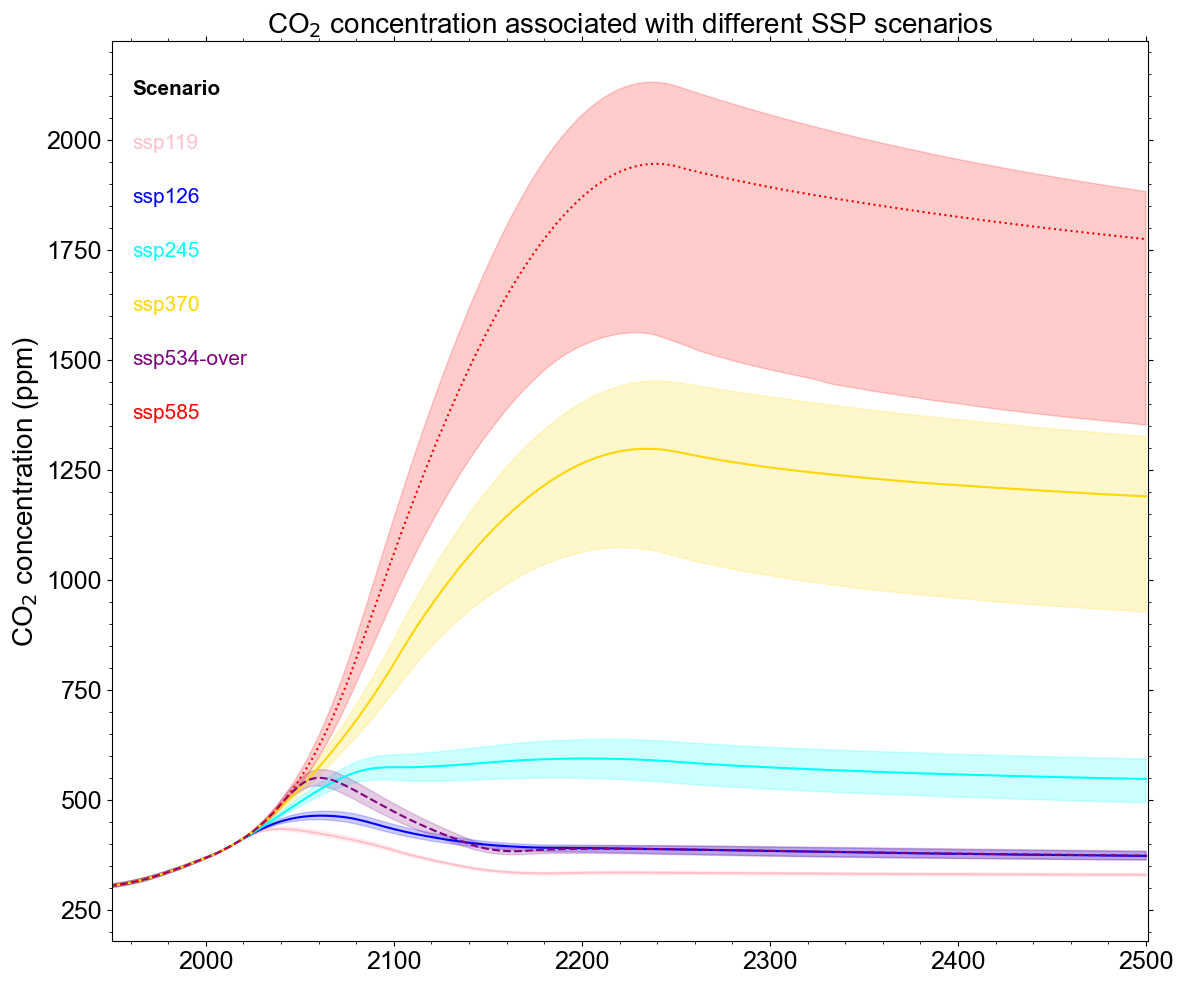

In [38]:
fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=15, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(1750,2501), np.percentile(results_out[scenario]['co2_conc'][0:751,:] , 5, axis=1), np.percentile(results_out[scenario]['co2_conc'][0:751,:] , 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(1750, 2501), np.median(results_out[scenario]['co2_conc'][0:751,:] , axis=1), color=colors[scenario], label=labels[scenario],linestyle=linestyle[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=15)
#ax.legend(fontsize=10);
ax.set_ylabel(r'CO${_2}$ concentration (ppm)', fontsize=20);
ax.set_title(r'CO${_2}$ concentration associated with different SSP scenarios', fontsize=20);
ax.set_xlim(1950, 2501)
#ax.set_ylim(-0.5, 1.5)

fig.tight_layout()
pl.savefig('../plots/ssp_CO2conc.png', dpi=500, transparent=False)

# All on the same plot ERF!

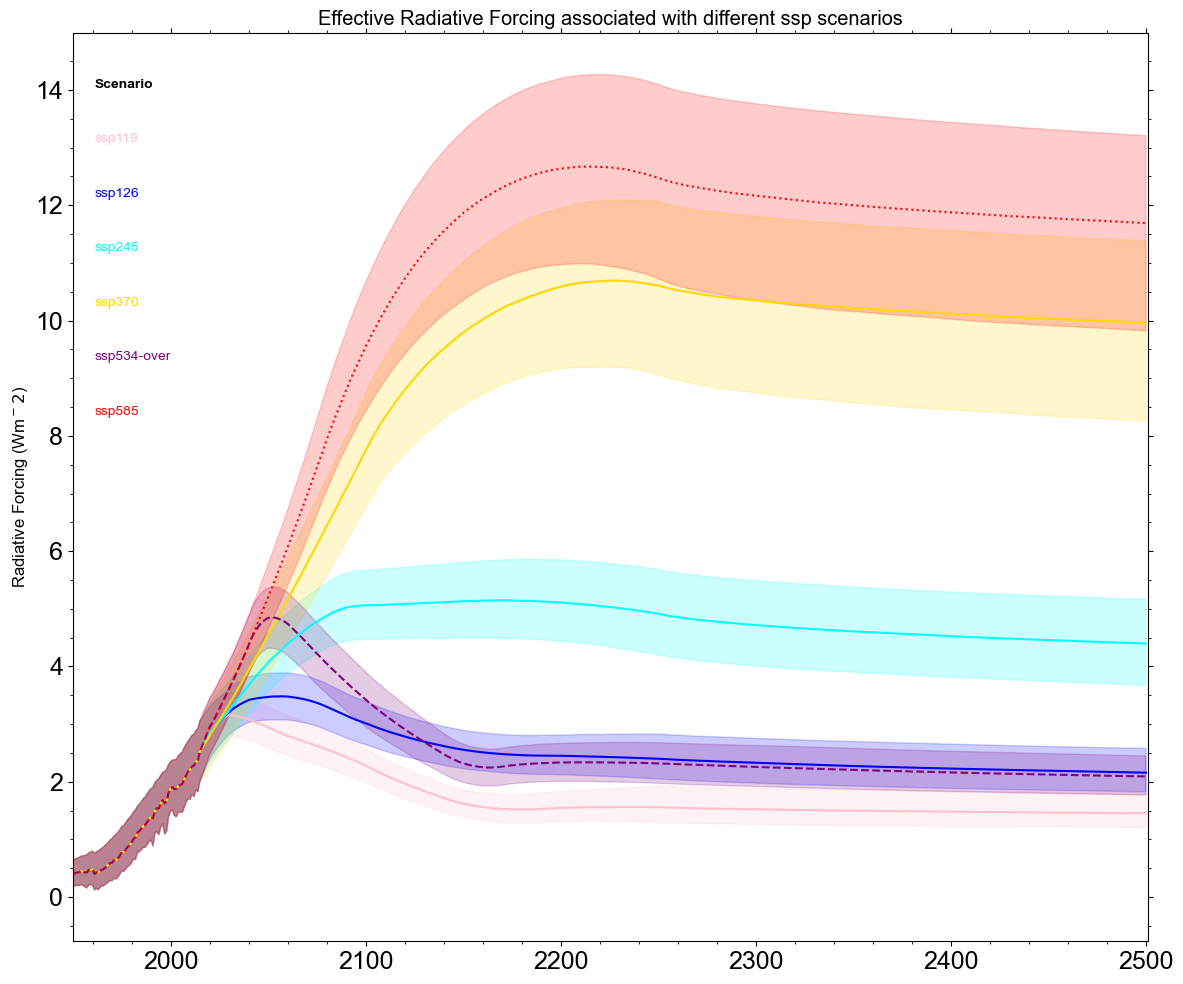

In [39]:
fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=10, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(1750,2501), np.percentile(results_out[scenario]['F_tot'][0:751,:] , 5, axis=1), np.percentile(results_out[scenario]['F_tot'][0:751], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(1750, 2501), np.median(results_out[scenario]['F_tot'][0:751,:] , axis=1), color=colors[scenario], linestyle=linestyle[scenario],label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=10)
#ax.legend(fontsize=10);
ax.set_ylabel(r'Radiative Forcing (Wm${^-2}$)');
ax.set_title('Effective Radiative Forcing associated with different ssp scenarios');
ax.set_xlim(1950, 2501)
#ax.set_ylim(-0.5, 1.5)

fig.tight_layout()
pl.savefig('../plots/ssp_erf.png', dpi=500, transparent=False)

In [40]:
# Output to csv, first create a dataframe 
model_archive = '../csv_FaIRoutputfiles_ssp/'
print (scenarios)
print 

if os.path.isdir(model_archive):
    print("Item already exists")
else:
    os.mkdir(model_archive)
    print ("Making the model directory")
    
#model_dir = model_archive+scenario+'/'
    

for scenario in scenarios:
    for variable in results_out[scenario].keys():
        years = 1750+np.arange(len(results_out[scenario][variable]))
        header_text = np.insert(years, 0, 0)
        dic = results_out[scenario][variable]
        
        
        SSPs = {'ssp119':'ssp119',
                'ssp126':'ssp126',
                'ssp245':'ssp245',
                'ssp370':'ssp370',
                'ssp534-over':'ssp534_over', 
                'ssp585':'ssp585'
          }
        
        filename='../csv_FaIRoutputfiles_ssp/ssprcmip_'+SSPs[scenario]+'_'+variable+'_csv'
        print(filename)
        pd.DataFrame(dic).T.reset_index().to_csv(filename, header=header_text, index=False)

['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp534-over', 'ssp585']
Item already exists
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp119_co2_conc_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp119_temp_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp119_temp_2_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp119_F_ant_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp119_F_aer_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp119_F_tot_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_co2_conc_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_temp_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_temp_2_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_F_ant_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_F_aer_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_F_tot_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_co2_conc_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_temp_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_temp_2_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_F_ant_csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_F_aer_csv
../c

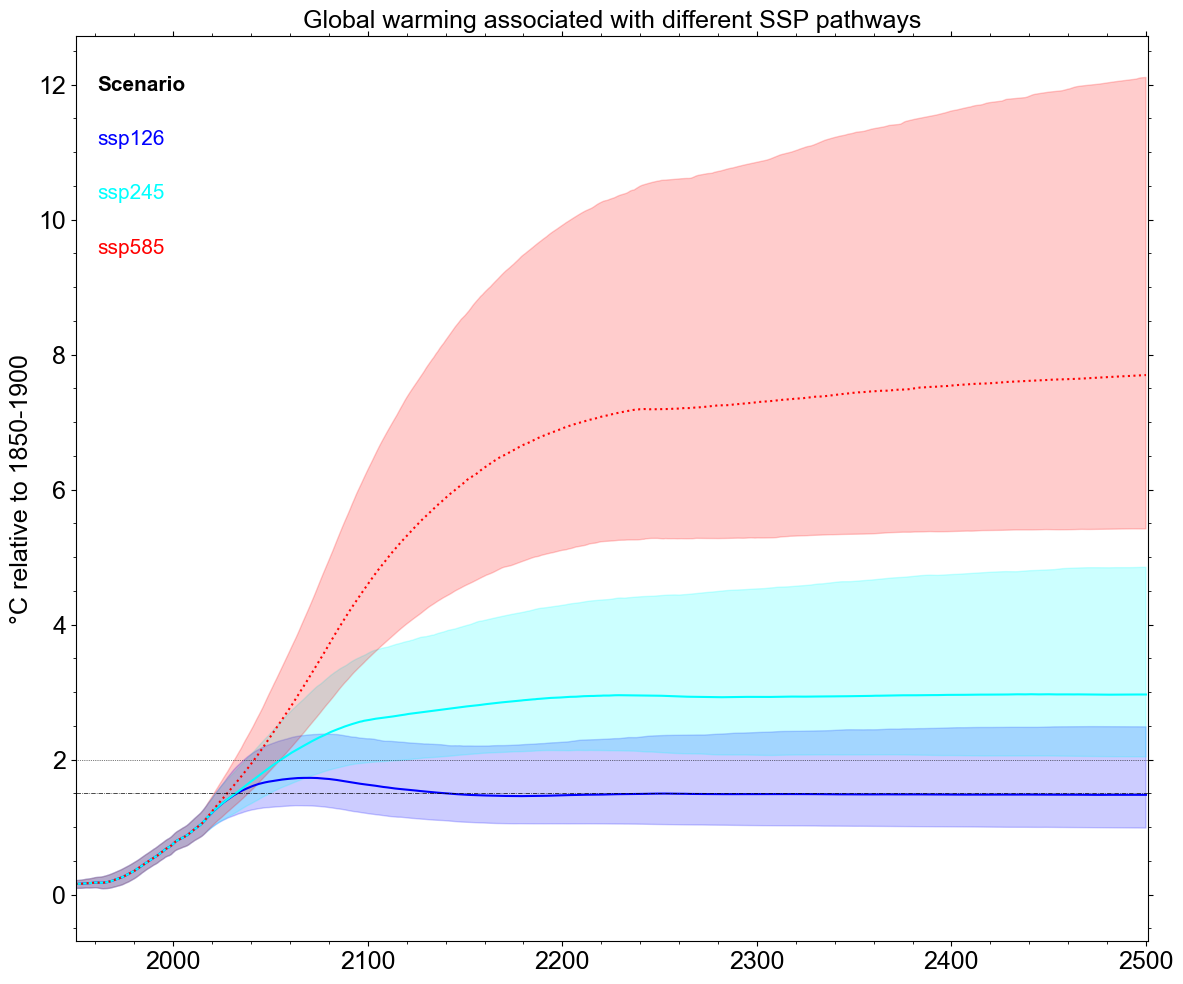

In [41]:
# subset of scenarios: SSP126, SSP245, SSP585


fig, ax = pl.subplots(figsize=(12, 10))

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=15, transform=ax.transAxes)
for i, scenario in enumerate(['ssp126','ssp245','ssp585']):
    ax.fill_between(np.arange(1750,2501), np.percentile(results_out[scenario]['temp'][0:751,:], 5, axis=1), np.percentile(results_out[scenario]['temp'][0:751,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(1750, 2501), np.median(results_out[scenario]['temp'][0:751,:] , axis=1), color=colors[scenario], label=labels[scenario], linestyle=linestyle[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=15)
#ax.legend(fontsize=10);
ax.set_ylabel('°C relative to 1850-1900', fontsize=18);
ax.set_title('Global warming associated with different SSP pathways', fontsize=18);
ax.set_xlim(1950, 2501)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

#ax1 = ax.twinx()
#positions = np.arange(0.75, 2.76, 0.25)

#ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

#ax1.set_ylim(0.75,2.75)
#ax1.spines['right'].set_color('gray')
#ax1.tick_params(axis='y', colors='gray')
#ax1.set_ylabel('°C relative to 1850-1900', color='gray', fontsize=18)


#ax.axhline(0, ls=':', color='k', lw=0.5)
ax.axhline(1.5, ls='-.', color='k', lw=0.5)
#ax1.axhline(1.75, ls='-.', color='k', lw=0.5)
ax.axhline(2.0, ls=':', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/ssp_126_245_585_temps.png', dpi=500, transparent=False)

Plots comparing temperature and co2 concentrations from FaIR. Doesn't rely on previous code just for the csv files to be there.

In [42]:
scenarios=['ssp585','ssp126','ssp119','ssp534_over','ssp370','ssp245']
ens_mems=[431,2037,1669,2236,1469,1523,1294,1015,1251]
ens_label=[0.0,0.01,0.05,0.25,0.5,0.75,0.95,0.99,1.]
dir='../csv_FaIRoutputfiles_ssp/'

scenario='ssp585'

file=dir+'ssprcmip_'+scenario+'_temp_csv'
# print(file)
# print('/home/h02/hadcam/github/FaIR_1.6_AR6/FaIR-Spice/csv_FaIRoutputfiles_orig/FaIR_output_for_temp_CO_Bridge.csv')
tas = np.genfromtxt(file, delimiter=',')

file=dir+'ssprcmip_'+scenario+'_co2_conc_csv'
co2 = np.genfromtxt(file, delimiter=',')

print(tas.shape)
print(co2.shape)
    

(2238, 752)
(2238, 752)


2100.0
0.0 2.47520048224778 1010.9925712712661
0.01 3.2228957535084217 971.1118161190657
0.05 3.3228987835635517 1046.549512432536
0.25 4.114876407470296 1002.2121986116422
0.5 4.546629843038519 987.4848222699504
0.75 4.817347892480463 1045.774489986235
0.95 6.083060428148649 1055.0840793346006
0.99 6.866528730967161 1016.5105165347793
1.0 7.816276735860412 1074.369093796675
2100.0
0.0 0.8490125171786277 428.83265378533673
0.01 1.0888898472929096 425.2945512690742
0.05 1.1875077233440354 434.1797656734933
0.25 1.438078660848421 427.50420473514237
0.5 1.6283157964085948 426.53422154078027
0.75 1.8176442584808257 432.40211932892896
0.95 2.2655932259726956 434.9854672796268
0.99 2.6879445201088648 430.3807193102829
1.0 3.3996075307794964 437.43223900282226
2100.0
0.0 0.6676930289691487 384.3320503486798
0.01 0.8337035525345682 381.72770188467786
0.05 0.9276063610919694 385.6165500107636
0.25 1.1149158561100603 382.4151186940301
0.5 1.2637347603053284 381.85429372267686
0.75 1.431348906396

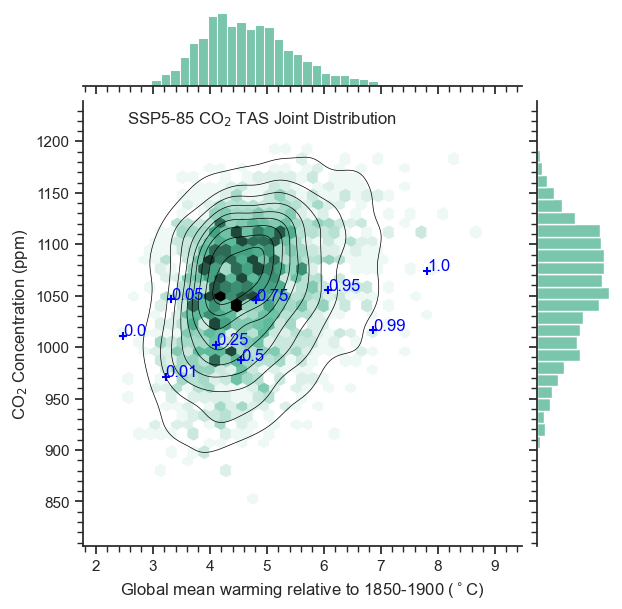

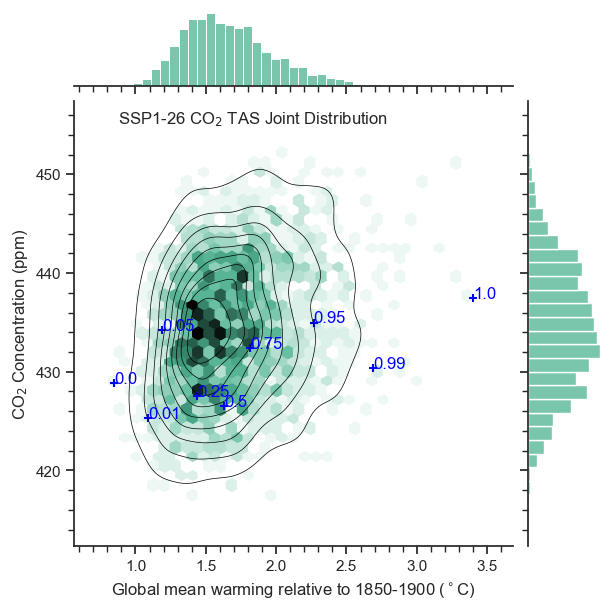

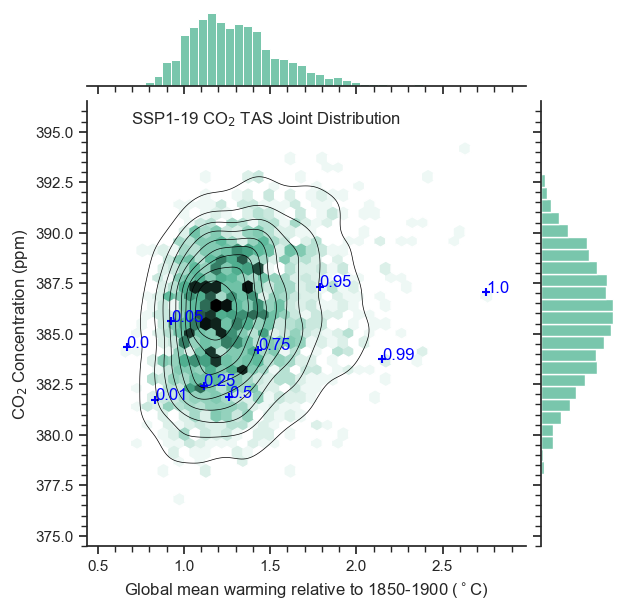

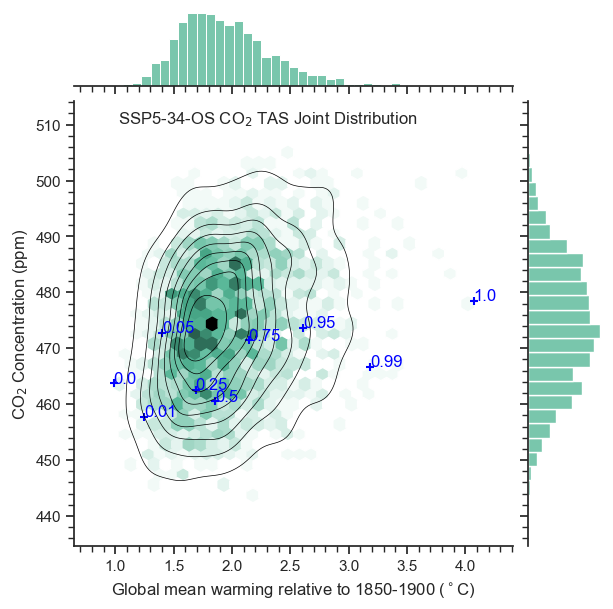

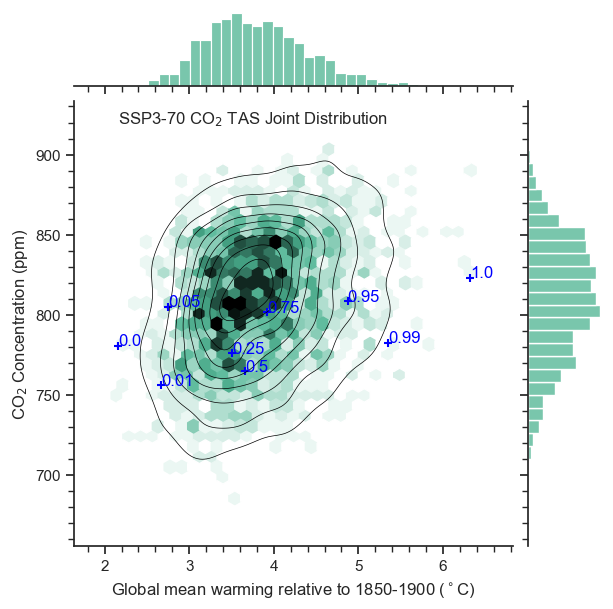

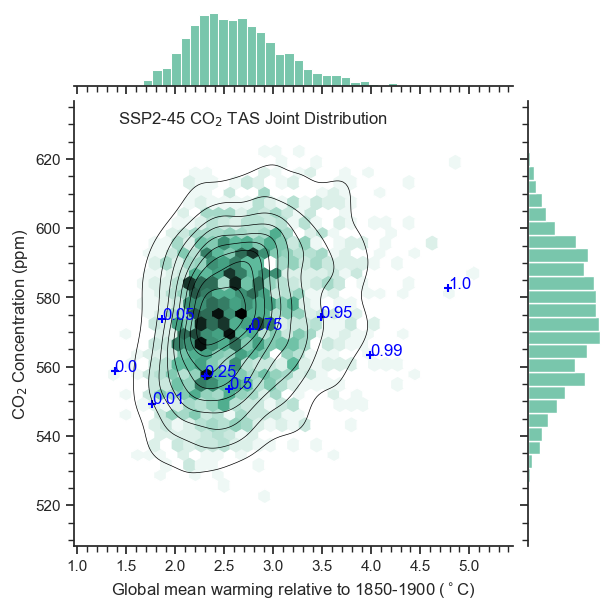

In [43]:
sns.set_theme(style="ticks")


scenarios=['ssp585','ssp126','ssp119','ssp534_over','ssp370','ssp245']
scenario_name = ['ssp5-85','ssp1-26','ssp1-19','ssp5-34-os','ssp3-70','ssp2-45']

for i, scenario in enumerate(scenarios):
        
    file=dir+'ssprcmip_'+scenario+'_temp_csv'
    tas = np.genfromtxt(file, delimiter=',')

    file=dir+'ssprcmip_'+scenario+'_co2_conc_csv'
    co2 = np.genfromtxt(file, delimiter=',')

    print(tas[0,351])

    x=tas[1:,351,]
    y=co2[1:,351,]

    p = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")
    p.plot_joint(sns.kdeplot, color='black',linewidths=0.5)
    plt.xlabel(r'Global mean warming relative to 1850-1900 ($^\circ$C)')
    plt.ylabel(r'CO$_{2}$ Concentration (ppm)')

    axes = plt.gca()
    y_min, y_max = axes.get_ylim()
    x_min, x_max = axes.get_xlim()
    
    # plt.text(2.,1200.,'SSP585 CO2 TAS Joint Distribution')
    plt.text(0.1*(x_max-x_min)+x_min,0.95*(y_max-y_min)+y_min,scenario_name[i].upper()+' CO$_{2}$ TAS Joint Distribution')
    
    for count, ens in enumerate(ens_mems):
        plt.scatter(tas[ens+0,351],co2[ens+0,351],marker='+',color='blue')
        plt.text(tas[ens+0,351],co2[ens+0,351],str(ens_label[count]),color='blue')
        print(ens_label[count],tas[ens+0,351],co2[ens+0,351])
        
    plt.savefig('../plots/'+scenario.replace(' ','_')+'.png',dpi=600)